In [1]:
# general purpose python
import collections
import datetime
import glob
import importlib
import itertools
import json
import math
import os
import pickle
import random
import re
import shutil
import sys
import time
import warnings

# general purpose data science
import IPython
import ipywidgets as ipw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs
import pylab
import scipy
import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm

# computer vision
import cv2
import imageio
import PIL
from PIL import *

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# geospatial
import rasterio as rio
import rasterio.features

warnings.filterwarnings('ignore')

np.random.seed(1337)

mpl.rcParams['figure.dpi'] = 400

IPython.core.display.display(IPython.core.display.HTML("<style>.container { width:100% !important; }</style>"))

pd.options.display.max_colwidth = 32
pd.options.display.float_format = '{:,.6f}'.format
pd.options.display.expand_frame_repr = False

%matplotlib inline

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

plotly.offline.init_notebook_mode(connected=True)
plotly.io.templates.default = 'plotly_white'

In [2]:
data_dir = '../../data/movielens/'

## Load the data

In [3]:
movies = pd.read_csv(f'{data_dir}/movies_clean.csv')
ratings = pd.read_csv(f'{data_dir}/ratings_train.csv')

## Compute scores

In [4]:
# calculate descriptive statistics about the ratings of each movie
movie_scores = ratings.groupby(['movie_id']).rating.agg(['count', 'mean', 'std'])
movie_scores.columns = ['ratings_cnt', 'ratings_avg', 'ratings_std']
movie_scores.sample(10)

,ratings_cnt,ratings_avg,ratings_std
movie_id,,,
93911,1,3.000000,nan
94044,7,3.214286,1.253566
127831,1,3.500000,nan
66927,4,4.000000,0.912871
70521,93,3.655914,0.969588
33358,131,3.660305,0.912029
99679,4,2.750000,1.658312
104633,1,3.500000,nan
333,8780,3.348349,1.065052


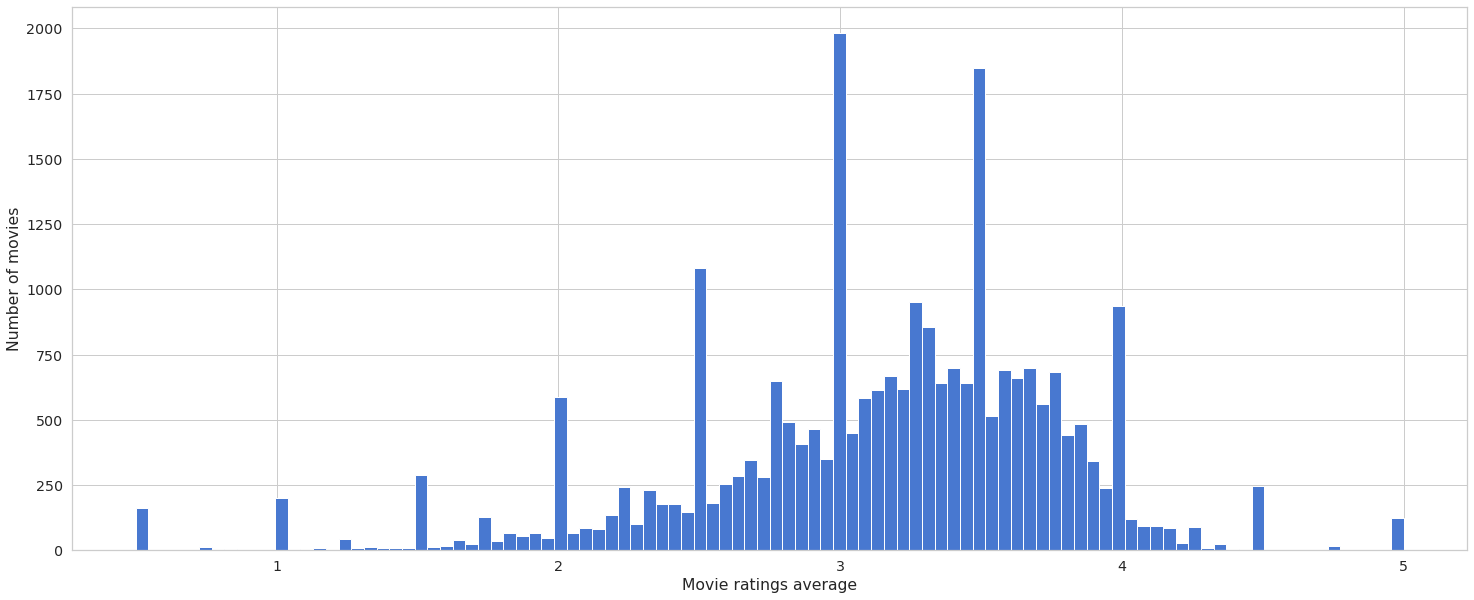

In [5]:
plt.figure(figsize=(25, 10))
plt.hist(movie_scores.ratings_avg.dropna(), bins=100)
plt.xlabel('Movie ratings average')
plt.ylabel('Number of movies')
plt.show()

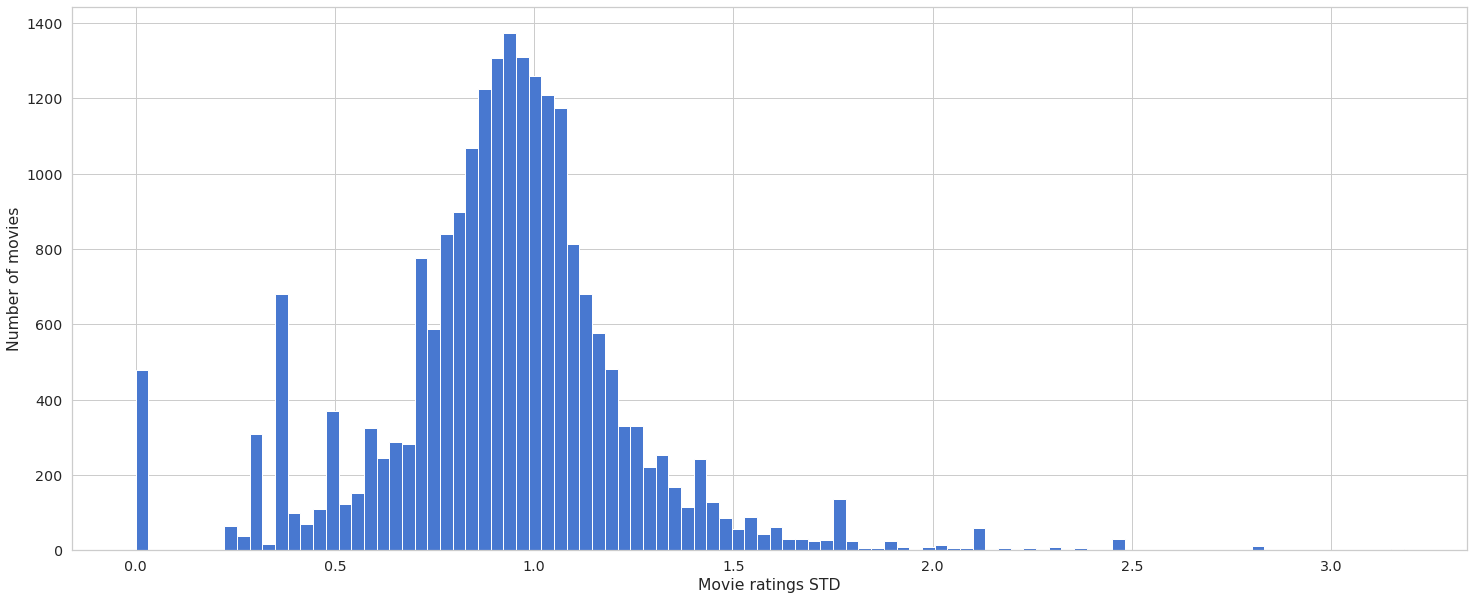

In [6]:
plt.figure(figsize=(25, 10))
plt.hist(movie_scores.ratings_std.dropna(), bins=100)
plt.xlabel('Movie ratings STD')
plt.ylabel('Number of movies')
plt.show()

In [7]:
# calculate quantiles of ratings average and STD
movie_scores['ratings_avg_qcut'] = pd.qcut(
    movie_scores.ratings_avg + (0.0001 * np.random.randn(len(movie_scores))),
    1000,
    labels=range(1, 1001)).astype(float)
movie_scores['ratings_std_qcut'] = pd.qcut(
    movie_scores.ratings_std + (0.0001 * np.random.randn(len(movie_scores))),
    1000,
    labels=range(1, 1001)).astype(float)

In [8]:
movies = pd.merge(movies, movie_scores, left_on='movie_id', right_index=True)
movies['age'] = 2019 - movies.year
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25871 entries, 0 to 27277
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_id              25871 non-null  int64  
 1   title                 25871 non-null  object 
 2   year                  25852 non-null  float64
 3   parsed_genres         25871 non-null  object 
 4   genre_children        25871 non-null  int64  
 5   genre_musical         25871 non-null  int64  
 6   genre_animation       25871 non-null  int64  
 7   genre_action          25871 non-null  int64  
 8   genre_western         25871 non-null  int64  
 9   genre_fantasy         25871 non-null  int64  
 10  genre_horror          25871 non-null  int64  
 11  genre_scifi           25871 non-null  int64  
 12  genre_crime           25871 non-null  int64  
 13  genre_adventure       25871 non-null  int64  
 14  genre_romance         25871 non-null  int64  
 15  genre_comedy       

In [9]:
movies.sample(10).T

,8429,7911,25277,1041,19691,24537,18777,21621,17090,25127
movie_id,25854,8594,119196,1061,97395,116157,93481,104767,86518,118686
title,Intermezzo (1939),"Secret Life of Girls, The (1...",Heartbeat (1938),Sleepers (1996),West of Memphis (2012),Electronic Labyrinth THX 113...,Miral (2010),"High Tech, Low Life (2012)","Student of Prague, The (a.k....",The Face of Love (2013)
year,"1,939.000000","1,999.000000","1,938.000000","1,996.000000","2,012.000000","1,967.000000","2,010.000000","2,012.000000","1,913.000000","2,013.000000"
parsed_genres,"['drama', 'romance']",['comedy'],['comedy'],['thriller'],['documentary'],['scifi'],['drama'],['documentary'],"['drama', 'horror']","['drama', 'romance']"
genre_children,0,0,0,0,0,0,0,0,0,0
genre_musical,0,0,0,0,0,0,0,0,0,0
genre_animation,0,0,0,0,0,0,0,0,0,0
genre_action,0,0,0,0,0,0,0,0,0,0
genre_western,0,0,0,0,0,0,0,0,0,0
genre_fantasy,0,0,0,0,0,0,0,0,0,0


## Some charts

### Top rated horror movies

In [10]:
print(movies[movies.genre_horror == 1].ratings_cnt.quantile([0.8 + i*0.05 for i in range(5)]))

0.800000      254.000000
0.850000      452.850000
0.900000      913.700000
0.950000    1,998.250000
1.000000   50,666.000000
Name: ratings_cnt, dtype: float64


In [11]:
d = movies[(movies.genre_horror == 1) & (movies.ratings_cnt > 1000)].copy()
d['score'] = (
    + 1.0 * d.ratings_avg_qcut
    - 0.1 * d.ratings_std_qcut
    + 0.001 * d.ratings_cnt)
d = d.sort_values(by='score', ascending=False)
d.head(30)[['movie_id', 'title', 'year', 'parsed_genres', 'ratings_avg', 'ratings_avg_qcut', 'ratings_std', 'ratings_std_qcut', 'ratings_cnt', 'score']]

,movie_id,title,year,parsed_genres,ratings_avg,ratings_avg_qcut,ratings_std,ratings_std_qcut,ratings_cnt,score
587,593,"Silence of the Lambs, The (1...","1,991.000000","['crime', 'horror', 'thriller']",4.178404,979.000000,0.840219,329.000000,50666,996.766000
2676,2762,"Sixth Sense, The (1999)","1,999.000000","['drama', 'horror', 'mystery']",4.053976,969.000000,0.830308,313.000000,31301,969.001000
1188,1214,Alien (1979),"1,979.000000","['horror', 'scifi']",4.035963,967.000000,0.887102,409.000000,24692,950.792000
1193,1219,Psycho (1960),"1,960.000000","['crime', 'horror']",4.075365,970.000000,0.860083,360.000000,15677,949.677000
1230,1258,"Shining, The (1980)","1,980.000000",['horror'],4.010937,964.000000,0.882488,401.000000,18744,942.644000
1175,1200,Aliens (1986),"1,986.000000","['action', 'adventure', 'hor...",4.002403,963.000000,0.896865,426.000000,21850,942.250000
12932,61240,Let the Right One In (Låt de...,"2,008.000000","['drama', 'fantasy', 'horror...",4.019333,965.000000,0.819731,298.000000,2457,937.657000
8191,8874,Shaun of the Dead (2004),"2,004.000000","['comedy', 'horror']",3.907893,915.000000,0.849025,341.000000,9337,890.237000
6875,6987,"Cabinet of Dr. Caligari, The...","1,920.000000","['crime', 'fantasy', 'horror']",3.917117,918.000000,0.898789,429.000000,1110,876.210000
1318,1348,"Nosferatu (Nosferatu, eine S...","1,922.000000",['horror'],3.911119,916.000000,0.944115,516.000000,2959,867.359000


### Controversial horror movies

In [12]:
print(movies[movies.genre_horror == 1].ratings_cnt.quantile([0.8 + i*0.05 for i in range(5)]))

0.800000      254.000000
0.850000      452.850000
0.900000      913.700000
0.950000    1,998.250000
1.000000   50,666.000000
Name: ratings_cnt, dtype: float64


In [13]:
d = movies[(movies.genre_horror == 1) & (movies.ratings_cnt > 1000)].copy()
d['score'] = (
    + 1.0 * d.ratings_avg_qcut
    + 2.0 * d.ratings_std_qcut
    + 0.001 * d.ratings_cnt)
d = d.sort_values(by='score', ascending=False)
d.head(30)[['movie_id', 'title', 'year', 'parsed_genres', 'ratings_avg', 'ratings_avg_qcut', 'ratings_std', 'ratings_std_qcut', 'ratings_cnt', 'score']]

,movie_id,title,year,parsed_genres,ratings_avg,ratings_avg_qcut,ratings_std,ratings_std_qcut,ratings_cnt,score
3585,3676,Eraserhead (1977),"1,977.000000","['drama', 'horror']",3.601064,767.000000,1.176877,858.000000,2068,"2,485.068000"
1213,1241,Dead Alive (Braindead) (1992),"1,992.000000","['comedy', 'fantasy', 'horror']",3.727473,837.000000,1.094301,779.000000,2042,"2,397.042000"
2571,2657,"Rocky Horror Picture Show, T...","1,975.000000","['comedy', 'horror', 'musica...",3.327519,562.000000,1.218264,885.000000,10778,"2,342.778000"
1233,1261,Evil Dead II (Dead by Dawn) ...,"1,987.000000","['action', 'comedy', 'fantas...",3.773547,865.000000,1.060698,735.000000,6211,"2,341.211000"
1898,1982,Halloween (1978),"1,978.000000",['horror'],3.543166,733.000000,1.107941,794.000000,5085,"2,326.085000"
2374,2459,"Texas Chainsaw Massacre, The...","1,974.000000",['horror'],3.202215,485.000000,1.293161,917.000000,2438,"2,321.438000"
951,968,Night of the Living Dead (1968),"1,968.000000","['horror', 'scifi', 'thriller']",3.628405,783.000000,1.083534,766.000000,6425,"2,321.425000"
2465,2550,"Haunting, The (1963)","1,963.000000","['horror', 'thriller']",3.619165,776.000000,1.083184,765.000000,1221,"2,307.221000"
8274,8957,Saw (2004),"2,004.000000","['horror', 'mystery', 'thril...",3.456090,644.000000,1.125615,813.000000,4384,"2,274.384000"
1913,1997,"Exorcist, The (1973)","1,973.000000","['horror', 'mystery']",3.746622,845.000000,1.044292,701.000000,10731,"2,257.731000"
